In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm

import pyqg
from pyqg import diagnostic_tools as tools

colors = [(0.33725, 0.70588, 0.91373),
          (0.90196, 0.62353, 0.00000),
          (0.00000, 0.61961, 0.45098),
          (0.94118, 0.89412, 0.25882),
          (0.00000, 0.44706, 0.69804),
          (0.83529, 0.36863, 0.00000),
          (0.80000, 0.47451, 0.65490)]

In [2]:
def save_with_snapshots(m, tsnapint):
    
    model_output = m_bt.to_dataset()
    
    for _ in m.run_with_snapshots(tsnapstart = 0., tsnapint = tsnapint):
        
        model_output = xr.concat([model_output, m_bt.to_dataset()], dim = 'time')
        
    return model_output

# Tests with my edits for *linear* topographic slopes

## Test two layer QG model with my edits to the kernel and qg_model (test without topographic slopes)

In [3]:
# Run 2 layer QG for 15 years

# Try to run with higher U

L =  1000e3     # length scale of box    [m]
Ld = 50e3       # deformation scale      [m]
kd = 1. / Ld    # deformation wavenumber [m^-1]
Nx = 256.       # number of grid points

U1 = 0.03        # layer 1 background zonal velocity [m/s]
U2 = 0.          # layer 2 background zonal velocity [m/s]
H1 = 500.        # depth of layer 1
delta = 1.       # layer depth ratio, \delta = H_1 / H_2, with total depth H = H_1 + H_2

rek = 1 / (25 * 24 * 60 * 60) # linear bottom drag coeff.  [s^-1]
f0  = 1e-4                    # coriolis param [s^-1]
beta = 1.5e-11                # planetary vorticity gradient [m^-1 s^-1]

year = 24 * 60 * 60 * 365.    
tmax = 15 * year
Ti = Ld / (abs(U1))   # estimate of most unstable e-folding time scale [s] (see 3-layer example in documentation)
dt = Ti / 200.        # time-step [s]

# Run the model for 15 years, and average over the last 5 years.

m = pyqg.QGModel(nx = Nx, L = L, rd = Ld, U1 = U1, U2 = U2, H1 = H1, delta = delta,
                 f = f0, beta = beta, rek = rek,
                 dt = dt / 2, tmax = tmax, twrite = 10000, tavestart = tmax - 5 * year)
# m.run()

INFO:  Logger initialized


NameError: name 'htop' is not defined

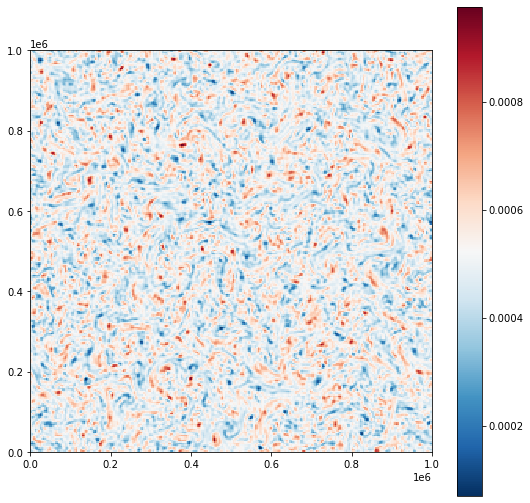

In [9]:
# Convert to xarray for nice metadata etc.

m_ds = m.to_dataset().isel(time=-1)

def plot_q(m, qmax=40):
    fig, ax = plt.subplots(figsize=(9,9))
    pc = ax.pcolormesh(m.x,m.y,m.q.squeeze(), cmap='RdBu_r')
    # pc.set_clim([-qmax, qmax])
    # ax.set_xlim([0, 2*np.pi])
    # ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    # plt.title('Time = %g' % m.t)
    plt.show()

plot_q(m_ds)

Notes: Success! The barotropic model runs well, meaning the very minimal changes I made to the kernel/bt_model.py module were not catostrophic to the model's normal running... Now let's try to test my changes by implenting a small slope in y.

## Test barotropic model with my edits to the kernel and BTModel (test with topographic slope in y)

Same parameters as experiment run above, except now with mild slopes in y

In [10]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
Ld = None# 100e3       # deformation radius    [m]
nx = 256.       # number of grid cells per direction

# Height and topography
H = 5e3         # Mean height of layer  [m]
hy = 1e-5 #1e-5   # Gradient of topographic slope in y
hx = 0. #   # Gradient of topographic slope in x

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 0.

# Time
dt = 10800 / 60                # time step [s]. NB: < 12500.0, which is the time step that worked with similar grid size for 2 layer model no topography
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 1000


# Create the model object
m_hy = pyqg.BTModel(L = L, rd = Ld, nx = nx,
                 f0 = f0, beta = beta, rek = rek,
                 H = H, hy = hy, hx = hx,
                 tmax = tmax, dt = dt, twrite = 10.)

m_hy.run()

INFO:  Logger initialized
INFO: Step: 10, Time: 1.80e+03, KE: 4.48e-01, CFL: 0.122
INFO: Step: 20, Time: 3.60e+03, KE: 4.46e-01, CFL: 0.125
INFO: Step: 30, Time: 5.40e+03, KE: 4.45e-01, CFL: 0.125
INFO: Step: 40, Time: 7.20e+03, KE: 4.44e-01, CFL: 0.128
INFO: Step: 50, Time: 9.00e+03, KE: 4.43e-01, CFL: 0.130
INFO: Step: 60, Time: 1.08e+04, KE: 4.42e-01, CFL: 0.128
INFO: Step: 70, Time: 1.26e+04, KE: 4.41e-01, CFL: 0.125
INFO: Step: 80, Time: 1.44e+04, KE: 4.40e-01, CFL: 0.124
INFO: Step: 90, Time: 1.62e+04, KE: 4.39e-01, CFL: 0.121
INFO: Step: 100, Time: 1.80e+04, KE: 4.39e-01, CFL: 0.123
INFO: Step: 110, Time: 1.98e+04, KE: 4.38e-01, CFL: 0.123
INFO: Step: 120, Time: 2.16e+04, KE: 4.37e-01, CFL: 0.123
INFO: Step: 130, Time: 2.34e+04, KE: 4.36e-01, CFL: 0.120
INFO: Step: 140, Time: 2.52e+04, KE: 4.36e-01, CFL: 0.123
INFO: Step: 150, Time: 2.70e+04, KE: 4.35e-01, CFL: 0.118
INFO: Step: 160, Time: 2.88e+04, KE: 4.34e-01, CFL: 0.119
INFO: Step: 170, Time: 3.06e+04, KE: 4.34e-01, CFL: 0.1

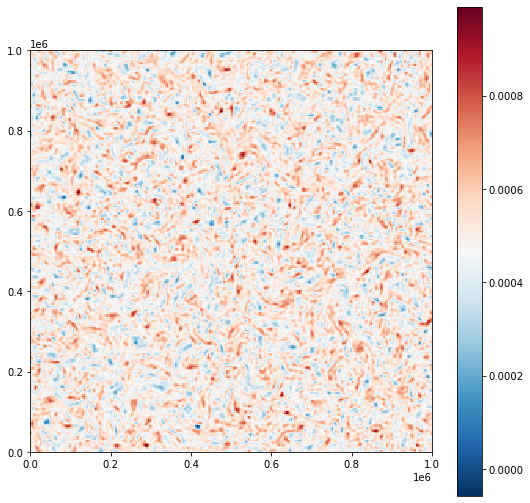

In [11]:
# Convert to xarray for nice metadata etc.

m_hy_ds = m_hy.to_dataset().isel(time=-1)

plot_q(m_hy_ds)

Success again! Model ran fine. To be excected: an $h_y = 1e-5$ slope is equivalent to adding a $1e-12$ term to $\beta = 1e-11$, which we expect therefore to have a small effect.\\

Now let's try with an $h_x \neq 0$ run!

## Test barotropic model with my edits to the kernel and BTModel (test with topographic slopes in y and x)

Same parameters as experiments run above, except now with mild slopes in y _and_ x

In [12]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
Ld = None# 100e3       # deformation radius    [m]
nx = 256.       # number of grid cells per direction

# Height and topography
H = 5e3     # Mean height of layer  [m]
hy = 1e-5   # Gradient of topographic slope in y
hx = 1e-5   # Gradient of topographic slope in x

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 0.

# Time
dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 1000


# Create the model object
m_hyhx = pyqg.BTModel(L = L, rd = Ld, nx = nx,
                 f0 = f0, beta = beta, rek = rek,
                 H = H, hy = hy, hx = hx,
                 tmax = tmax, dt = dt, twrite = 10.)

m_hyhx.run()

INFO:  Logger initialized
INFO: Step: 10, Time: 1.80e+03, KE: 5.22e-01, CFL: 0.130
INFO: Step: 20, Time: 3.60e+03, KE: 5.20e-01, CFL: 0.131
INFO: Step: 30, Time: 5.40e+03, KE: 5.19e-01, CFL: 0.128
INFO: Step: 40, Time: 7.20e+03, KE: 5.18e-01, CFL: 0.140
INFO: Step: 50, Time: 9.00e+03, KE: 5.17e-01, CFL: 0.138
INFO: Step: 60, Time: 1.08e+04, KE: 5.16e-01, CFL: 0.140
INFO: Step: 70, Time: 1.26e+04, KE: 5.15e-01, CFL: 0.144
INFO: Step: 80, Time: 1.44e+04, KE: 5.14e-01, CFL: 0.141
INFO: Step: 90, Time: 1.62e+04, KE: 5.13e-01, CFL: 0.136
INFO: Step: 100, Time: 1.80e+04, KE: 5.12e-01, CFL: 0.142
INFO: Step: 110, Time: 1.98e+04, KE: 5.12e-01, CFL: 0.144
INFO: Step: 120, Time: 2.16e+04, KE: 5.11e-01, CFL: 0.143
INFO: Step: 130, Time: 2.34e+04, KE: 5.10e-01, CFL: 0.139
INFO: Step: 140, Time: 2.52e+04, KE: 5.10e-01, CFL: 0.135
INFO: Step: 150, Time: 2.70e+04, KE: 5.09e-01, CFL: 0.137
INFO: Step: 160, Time: 2.88e+04, KE: 5.08e-01, CFL: 0.137
INFO: Step: 170, Time: 3.06e+04, KE: 5.08e-01, CFL: 0.1

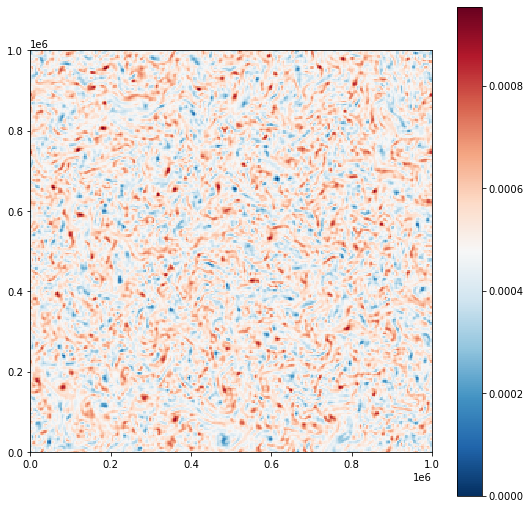

In [13]:
# Convert to xarray for nice metadata etc.

m_hyhx_ds = m_hyhx.to_dataset().isel(time=-1)

plot_q(m_hyhx_ds)

## Test barotropic model with my edits to the kernel and BTModel (test with topographic slopes in y and x and deformation)

Same parameters as experiments run above, except now with mild slopes in y _and_ x

In [25]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
nx = 256.       # number of grid cells per direction

# Height and topography
H = 5e3     # Mean height of layer  [m]
hy = 1e-5   # Gradient of topographic slope in y
hx = 1e-5   # Gradient of topographic slope in x

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)

rek = 0.

g = 9.81
Ld = np.sqrt(g * H) / f0

# Time
dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 1000


# Create the model object
m_hyhx = pyqg.BTModel(L = L, rd = Ld, nx = nx,
                 f0 = f0, beta = beta, rek = rek,
                 H = H, hy = hy, hx = hx,
                 tmax = tmax, dt = dt, twrite = 10.)

m_hyhx.run()

INFO:  Logger initialized
INFO: Step: 10, Time: 1.80e+03, KE: 4.61e-01, CFL: 0.143
INFO: Step: 20, Time: 3.60e+03, KE: 4.60e-01, CFL: 0.141
INFO: Step: 30, Time: 5.40e+03, KE: 4.58e-01, CFL: 0.142
INFO: Step: 40, Time: 7.20e+03, KE: 4.57e-01, CFL: 0.145
INFO: Step: 50, Time: 9.00e+03, KE: 4.56e-01, CFL: 0.146
INFO: Step: 60, Time: 1.08e+04, KE: 4.56e-01, CFL: 0.143
INFO: Step: 70, Time: 1.26e+04, KE: 4.55e-01, CFL: 0.147
INFO: Step: 80, Time: 1.44e+04, KE: 4.54e-01, CFL: 0.147
INFO: Step: 90, Time: 1.62e+04, KE: 4.53e-01, CFL: 0.144
INFO: Step: 100, Time: 1.80e+04, KE: 4.52e-01, CFL: 0.143
INFO: Step: 110, Time: 1.98e+04, KE: 4.52e-01, CFL: 0.144
INFO: Step: 120, Time: 2.16e+04, KE: 4.51e-01, CFL: 0.140
INFO: Step: 130, Time: 2.34e+04, KE: 4.50e-01, CFL: 0.135
INFO: Step: 140, Time: 2.52e+04, KE: 4.49e-01, CFL: 0.136
INFO: Step: 150, Time: 2.70e+04, KE: 4.49e-01, CFL: 0.135
INFO: Step: 160, Time: 2.88e+04, KE: 4.48e-01, CFL: 0.131
INFO: Step: 170, Time: 3.06e+04, KE: 4.47e-01, CFL: 0.1

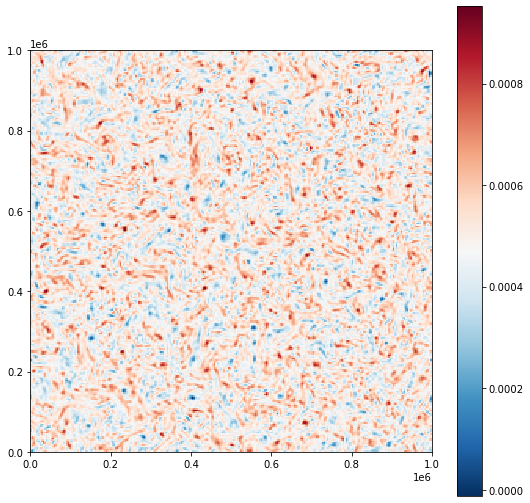

In [26]:
# Convert to xarray for nice metadata etc.

m_hyhx_ds = m_hyhx.to_dataset().isel(time=-1)

plot_q(m_hyhx_ds)

## Real test: barotropic model attempt to run for many years

Use same parameters as used in the previous experiment, except now try to run for several years

In [248]:
# Grid, dimensions
L =  1000e3     # side length of domain   [m]
nx = 256.       # number of grid cells per direction

# Height and topography
H = 5e3         # mean height of layer   [m]
hy = 1e-3       # Gradient of topographic slope in y
hx = 1e-3       # Gradient of topographic slope in x

# Planetary stuff
f0 = 1e-4                               # Coriolis frequency [/s]
omega = 7.2921159e-5                    # Angular frequency of Earth [rad/s]
a = 6.371e6                             # 
lat = np.arcsin(f0 / (2 * omega))
beta = 0. #2 * omega / a * np.cos(lat)

rek = 0.
g = 9.81
Ld = None #np.sqrt(g * H) / f0       # deformation radius    [m]

# Time
year = 60 * 60 * 24 * 365. # year [s] 
tmax = year * 2.5           # time of integration [s]
dt = 300                   # time step [s]

tavestart = year           # start averaging after 1 year [s]
taveint = 60 * 60 * 24     # daily averages [s]


# Create the model object
m_bt = pyqg.BTModel(L = L, rd = Ld, nx = nx,
                 f0 = f0, beta = beta, rek = rek,
                 H = H, hy = hy, hx = hx,
                 tmax = tmax, dt = dt,
                 tavestart = 0., taveint = taveint, twrite = 5000.)

INFO:  Logger initialized


In [250]:
m_bt_ds = save_with_snapshots(m_bt, tsnapint = taveint)

INFO: Step: 5000, Time: 1.50e+06, KE: 4.11e-01, CFL: 0.203
INFO: Step: 10000, Time: 3.00e+06, KE: 4.07e-01, CFL: 0.213
INFO: Step: 15000, Time: 4.50e+06, KE: 4.04e-01, CFL: 0.208
INFO: Step: 20000, Time: 6.00e+06, KE: 4.02e-01, CFL: 0.202
INFO: Step: 25000, Time: 7.50e+06, KE: 4.00e-01, CFL: 0.167
INFO: Step: 30000, Time: 9.00e+06, KE: 3.99e-01, CFL: 0.196
INFO: Step: 35000, Time: 1.05e+07, KE: 3.97e-01, CFL: 0.168
INFO: Step: 40000, Time: 1.20e+07, KE: 3.96e-01, CFL: 0.193
INFO: Step: 45000, Time: 1.35e+07, KE: 3.95e-01, CFL: 0.171
INFO: Step: 50000, Time: 1.50e+07, KE: 3.93e-01, CFL: 0.175
INFO: Step: 55000, Time: 1.65e+07, KE: 3.92e-01, CFL: 0.164
INFO: Step: 60000, Time: 1.80e+07, KE: 3.91e-01, CFL: 0.184
INFO: Step: 65000, Time: 1.95e+07, KE: 3.90e-01, CFL: 0.182
INFO: Step: 70000, Time: 2.10e+07, KE: 3.89e-01, CFL: 0.156
INFO: Step: 75000, Time: 2.25e+07, KE: 3.88e-01, CFL: 0.152
INFO: Step: 80000, Time: 2.40e+07, KE: 3.87e-01, CFL: 0.179
INFO: Step: 85000, Time: 2.55e+07, KE: 3.

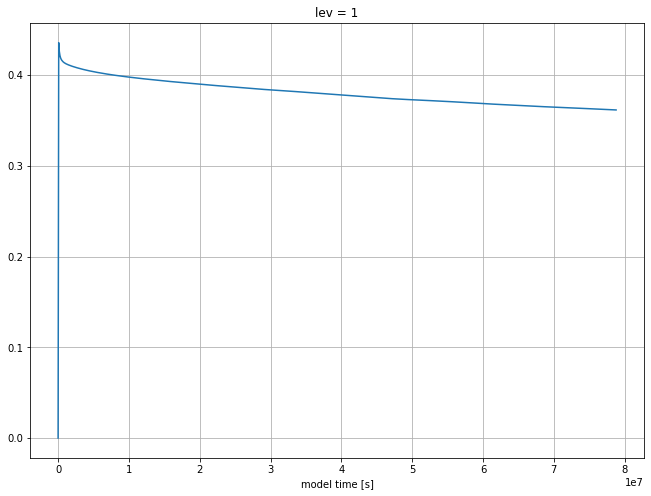

In [258]:
m_bt_ke_area = 0.5 * (m_bt_ds.u ** 2 + m_bt_ds.v ** 2).mean(dim = ['x', 'y'])

plt.figure(figsize=(11,8))

m_bt_ke_area.plot()
plt.grid()

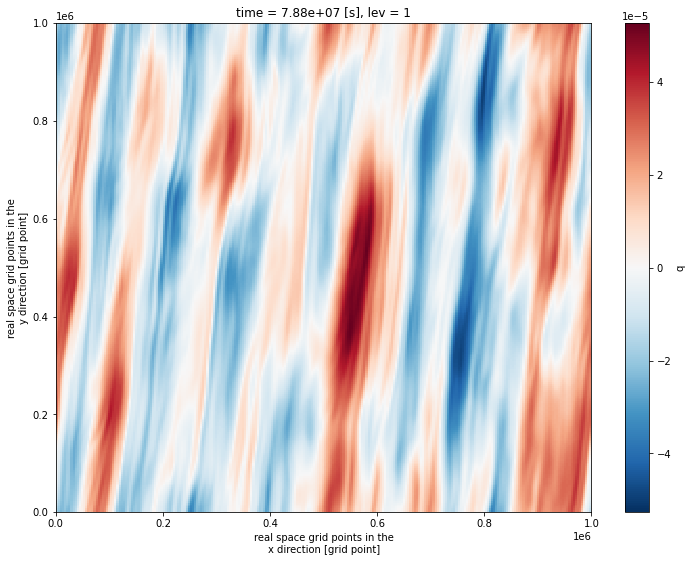

In [269]:
q = m_bt_ds.q.isel(time=-1)
q_anom = q - q.mean()

plt.figure(figsize=(12,9))
q_anom.plot()

In [286]:
p = m_bt_ds.p.isel(time = slice(-365, None))
# p_time_mean = p.mean(dim='time')
p_anom = p_time_mean - p_time_mean.mean()

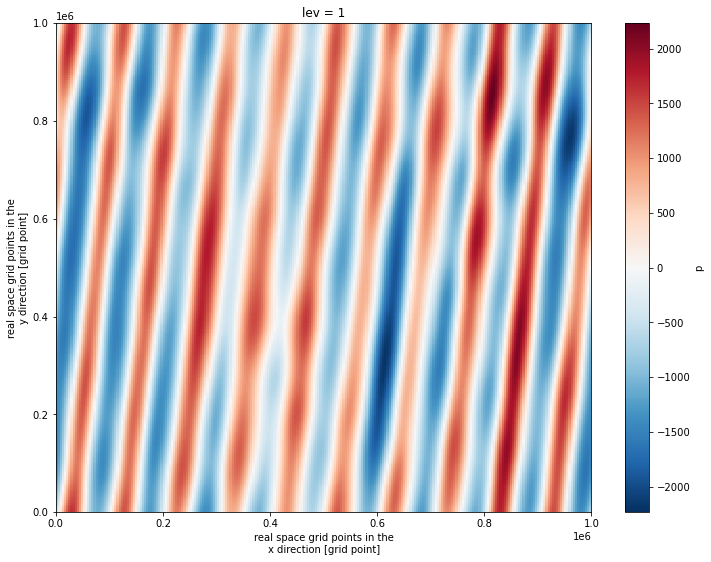

In [288]:
plt.figure(figsize=(12,9))


p_anom.plot()

#### Set initial condition so that all energy is initially in a ring to test Vallis Maltrud 1993 simulation but with varying topography

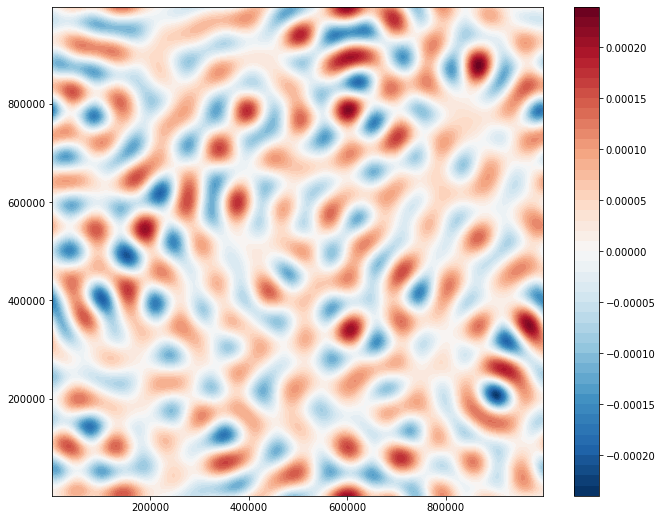

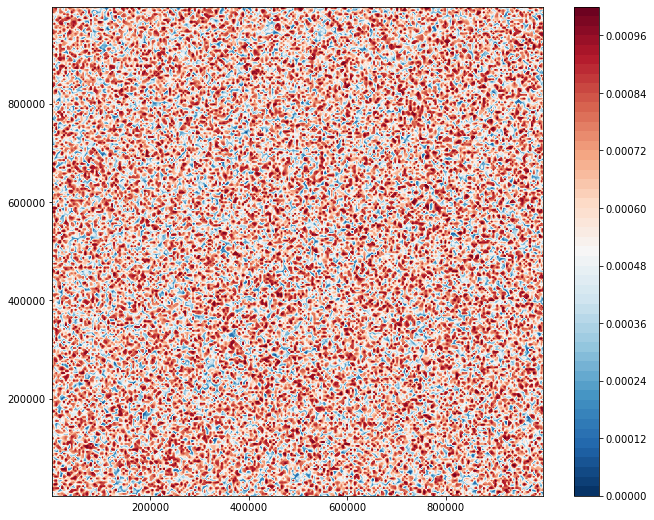

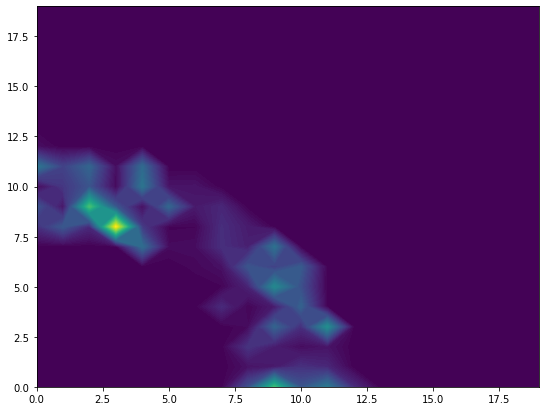

In [50]:
# Ring energy spectrum

K_ring_inner = 8. * (2 * np.pi / m_bt.L)
K_ring_outer = 12. * (2 * np.pi / m_bt.L)

nhx,nhy = m_bt.wv.shape
wvx = np.sqrt((m_bt.k)**2.+(m_bt.l)**2.)
        
mask = np.ones_like(wvx)
mask[wvx < K_ring_inner] = 0.
mask[wvx > K_ring_outer] = 0.

ring_hat = mask * (np.random.randn(nhx,nhy) + 1j * np.random.randn(nhx,nhy))

ring = m_bt.ifft( ring_hat[np.newaxis, :, :] )
ring = ring# - ring.mean()

ring_hat = m_bt.fft( ring )

KEaux = m_bt.spec_var( m_bt.wv * ring_hat )

pih = ring_hat / np.sqrt(KEaux)
qih = - m_bt.wv2 * pih

qi = m_bt.ifft(qih)

m_bt_ds.q.isel(lev=0) + (beta + f0 / H * hy) * m_bt_ds.y + (f0 / H * hx) * m_bt_ds.x

plt.figure(figsize=(11,9))
plt.contourf(m_bt.x, m_bt.y, qi.squeeze() + (beta + f0 / H * hy) * m_bt_ds.y.data + (f0 / H * hx) * m_bt_ds.x.data, cmap='RdBu_r', levels=50)
plt.colorbar()

plt.figure(figsize=(11,9))
plt.contourf(m_bt.x, m_bt.y, m_bt_test.q.squeeze() + (beta + f0 / H * hy) * m_bt_ds.y.data + (f0 / H * hx) * m_bt_ds.x.data, cmap='RdBu_r', levels=50)
plt.colorbar()

e_spec = np.abs(pih.squeeze()) ** 2

k = m_bt.k / (2 * np.pi / m_bt.L)
l = m_bt.l / (2 * np.pi / m_bt.L)

plt.figure(figsize=(9,7))
index = 20

plt.contourf(k[:index, :index],
             l[:index, :index],
             e_spec[:index, :index], levels=100)

# initialize the model with that initial condition
# m_bt_test.set_q(qi)

def plot_q(m):
    fig, ax = plt.subplots()
    x = m.x#.data
    y = m.y#.data
    
    pc = ax.pcolormesh(x, y, m.q.squeeze() + (beta + f0 / H * hy) * y + (f0 / H * hx) * x, cmap='RdBu_r')
    # pc.set_clim([-qmax, qmax])
    # ax.set_xlim([0, 2*np.pi])
    # ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    plt.title('Time = %g' % m.t)
    plt.show()

# Tests with my edits for *rough* topography

## Test barotropic model with my edits to the kernel and BTModel (test without topography)

In [3]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
Ld = None# 100e3       # deformation radius    [m]
nx = 256.       # number of grid cells per direction

# Height and topography
H = 5e3         # Mean height of layer  [m]
hy = 0. #1e-5   # Gradient of topographic slope in y
hx = 0. #1e-5   # Gradient of topographic slope in x

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 0.

# Time
dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 1000


# Create the model object
m = pyqg.BTModel(L = L, rd = Ld, nx = nx,
                 f0 = f0, beta = beta, rek = rek,
                 H = H, hy = hy, hx = hx,
                 tmax = tmax, dt = dt, twrite = 10.)

m.run()

INFO:  Logger initialized
INFO: Step: 10, Time: 1.80e+03, KE: 4.72e-01, CFL: 0.124
INFO: Step: 20, Time: 3.60e+03, KE: 4.71e-01, CFL: 0.126
INFO: Step: 30, Time: 5.40e+03, KE: 4.69e-01, CFL: 0.129
INFO: Step: 40, Time: 7.20e+03, KE: 4.69e-01, CFL: 0.131
INFO: Step: 50, Time: 9.00e+03, KE: 4.68e-01, CFL: 0.133
INFO: Step: 60, Time: 1.08e+04, KE: 4.67e-01, CFL: 0.133
INFO: Step: 70, Time: 1.26e+04, KE: 4.66e-01, CFL: 0.132
INFO: Step: 80, Time: 1.44e+04, KE: 4.65e-01, CFL: 0.132
INFO: Step: 90, Time: 1.62e+04, KE: 4.64e-01, CFL: 0.133
INFO: Step: 100, Time: 1.80e+04, KE: 4.63e-01, CFL: 0.132
INFO: Step: 110, Time: 1.98e+04, KE: 4.63e-01, CFL: 0.131
INFO: Step: 120, Time: 2.16e+04, KE: 4.62e-01, CFL: 0.131
INFO: Step: 130, Time: 2.34e+04, KE: 4.61e-01, CFL: 0.130
INFO: Step: 140, Time: 2.52e+04, KE: 4.60e-01, CFL: 0.130
INFO: Step: 150, Time: 2.70e+04, KE: 4.60e-01, CFL: 0.125
INFO: Step: 160, Time: 2.88e+04, KE: 4.59e-01, CFL: 0.127
INFO: Step: 170, Time: 3.06e+04, KE: 4.59e-01, CFL: 0.1

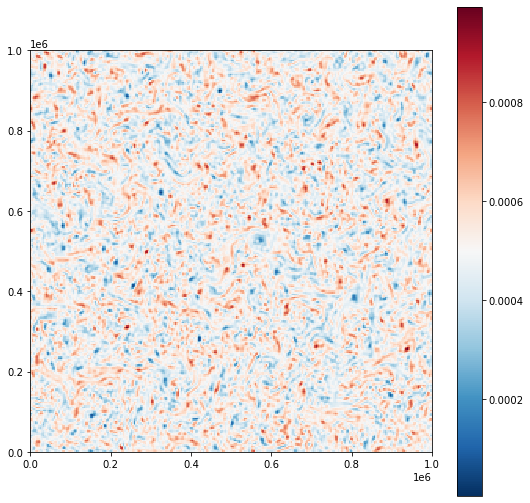

In [4]:
# Convert to xarray for nice metadata etc.

m_ds = m.to_dataset().isel(time=-1)

def plot_q(m, qmax=40):
    fig, ax = plt.subplots(figsize=(9,9))
    pc = ax.pcolormesh(m.x,m.y,m.q.squeeze(), cmap='RdBu_r')
    # pc.set_clim([-qmax, qmax])
    # ax.set_xlim([0, 2*np.pi])
    # ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    # plt.title('Time = %g' % m.t)
    plt.show()

plot_q(m_ds)

## Test barotropic model with my edits to the kernel and BTModel (test with small rough topography)

In [53]:
# Grid, dimensions
L =  1000e3     # length scale of box   [m]
Ld = None# 100e3       # deformation radius    [m]
nx = 256.       # number of grid cells per direction
ny = nx

# Height and topography
H = 5e3         # Mean height of layer  [m]
hy = 0. #1e-5   # Gradient of topographic slope in y
hx = 0. #1e-5   # Gradient of topographic slope in x

def zero_mean_bump(h, n, L, xx, yy):
    
    return h * np.sin(2*n * np.pi / L * xx) * np.sin(2*n * np.pi / L * yy)

def non_zero_mean_bump(h, n, L, xx, yy):
    
    c = 1.
    
    return h * (np.cos(2*n * np.pi / L * c * xx) + np.sin(2*n * np.pi / L * c * yy))

x = np.linspace(0., L, int(nx))
y = np.linspace(0., L, int(nx))
xx, yy = np.meshgrid(x, y)

htop = 100 * zero_mean_bump(1, 3, L, xx, yy)
# htop = non_zero_mean_bump(1, 3, L, xx, yy)

# Planetary stuff
f0 = 1e-4
omega = 7.2921159e-5
a = 6.371e6
lat = np.arcsin(f0 / (2 * omega))
beta = 2 * omega / a * np.cos(lat)
rek = 0.

# Time
dt = 10800 / 60                # time step [s].
# tmax = 60 * 60 * 24 * 5        # model run time [s]
tmax = dt * 10000


# Create the model object
m = pyqg.BTModel(L = L, rd = Ld, nx = nx,
                 f0 = f0, beta = beta, rek = rek,
                 H = H, hy = hy, hx = hx, htop = htop,
                 tmax = tmax, dt = dt, twrite = 1000.)

# plt.contourf(xx, yy, m.htop[0,:,:] + 1e-2 * yy)
# plt.colorbar()

m.run()

INFO:  Logger initialized
INFO: Step: 1000, Time: 1.80e+05, KE: 3.14e-01, CFL: 0.128
INFO: Step: 2000, Time: 3.60e+05, KE: 2.81e-01, CFL: 0.124
INFO: Step: 3000, Time: 5.40e+05, KE: 2.59e-01, CFL: 0.112
INFO: Step: 4000, Time: 7.20e+05, KE: 2.42e-01, CFL: 0.114
INFO: Step: 5000, Time: 9.00e+05, KE: 2.30e-01, CFL: 0.101
INFO: Step: 6000, Time: 1.08e+06, KE: 2.20e-01, CFL: 0.116
INFO: Step: 7000, Time: 1.26e+06, KE: 2.12e-01, CFL: 0.112
INFO: Step: 8000, Time: 1.44e+06, KE: 2.06e-01, CFL: 0.108
INFO: Step: 9000, Time: 1.62e+06, KE: 2.01e-01, CFL: 0.107
INFO: Step: 10000, Time: 1.80e+06, KE: 1.97e-01, CFL: 0.115


In [68]:
beta = 1.5e-11
omega = 7.2921159e-5
a = 6.371e6
lat = np.arccos(a * beta / (2 * omega))
f0 = 2 * omega * np.sin(lat)
f0

0.00011016947169980042

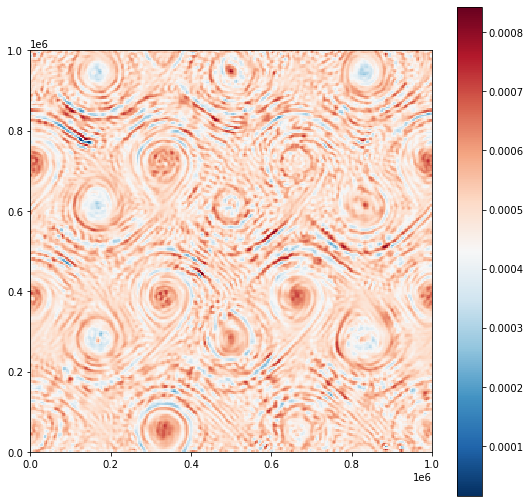

In [54]:
# Convert to xarray for nice metadata etc.

m_ds = m.to_dataset().isel(time=-1)

def plot_q(m, qmax=40):
    fig, ax = plt.subplots(figsize=(9,9))
    pc = ax.pcolormesh(m.x,m.y,m.q.squeeze(), cmap='RdBu_r')
    # pc.set_clim([-qmax, qmax])
    # ax.set_xlim([0, 2*np.pi])
    # ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    # plt.title('Time = %g' % m.t)
    plt.show()

plot_q(m_ds)

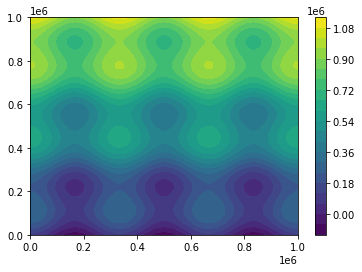

In [63]:
plt.contourf(xx, yy, m.htop[0,:,:] + 1 * yy, levels=20)
plt.colorbar()